In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from tqdm.auto import tqdm
from sklearn import metrics
import seaborn as sns
import pandas as pd

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [ ]:
MNIST_TRAIN = datasets.MNIST("data", download=True)
MNIST_TEST = datasets.MNIST("data", download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
FASHION_MNIST_TRAIN = datasets.FashionMNIST("data", download=True)
FASHION_MNIST_TEST = datasets.FashionMNIST("data", train=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
CIFAR_TRAIN = datasets.CIFAR10("data", download=True)
CIFAR_TEST = datasets.CIFAR10("data", download=True, train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [16]:
def calculate_accuracy(predictions, grs):
    """Multiclass problem accuracy"""
    predictions = torch.softmax(predictions, dim=1)
    predictions = torch.argmax(predictions, dim=1)
    return (torch.sum(predictions == grs) / len(grs)).item()

In [17]:
def classification_loop(train_loader, test_loader, model, criterion, optimizer, epochs, device="cpu"):
    """Training loop for c-class classification problem"""
    train_loss_history = []
    test_loss_history = []
    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        train_acc = 0.0
        test_loss = 0.0
        test_acc = 0.0
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            model.zero_grad()
            predictions = model(x_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += calculate_accuracy(predictions, y_batch)
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_loss_history.append(train_loss)
        
        with torch.inference_mode():
            model.eval()
            for x_test_batch, y_test_batch in test_loader:
                x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)
                test_predictions = model(x_test_batch)
                test_loss += criterion(test_predictions, y_test_batch).item()
                test_acc += calculate_accuracy(test_predictions, y_test_batch)
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)
        test_loss_history.append(test_loss)
        print(f"Epoch: {epoch} | Train loss: {train_loss} | Train acc: {train_acc} | Test loss: {test_loss} |\
Test acc: {test_acc}")
    return train_loss_history, test_loss_history

In [18]:
def make_confusion_matrix(loader, model, labels, device):
    with torch.inference_mode():
        test_predictions = []
        test_grs = []
        for x, y in loader:
            x = x.to(device)
            preds = model(x)
            test_predictions += list(torch.argmax(preds, dim=1).cpu())
            test_grs += list(y)
    plt.figure(figsize=(12, 9))
    sns.heatmap(metrics.confusion_matrix(test_grs, test_predictions),
                xticklabels=labels,
                yticklabels=labels,
                cmap="viridis",
                annot=True);

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [ ]:
class MNISTDataset(Dataset):
    
    def __init__(self,
                 train: bool = True,
                 transforms=None):
        if train:
            self.X = FASHION_MNIST_TRAIN.data
            self.y = FASHION_MNIST_TRAIN.targets
        else:
            self.X = FASHION_MNIST_TEST.data
            self.y = FASHION_MNIST_TEST.targets
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        x = self.X[index]
        y = self.y[index]
        if self.transforms:
            x = self.transforms(x)
        x = torch.flatten(x, start_dim=0)
        return x, y

    def __len__(self):
        return self.X.shape[0]

In [ ]:
class MNISTFCModel(nn.Module):
    
    def __init__(self,
                 in_neurons: int,
                 hidden_neurons: int,
                 out_neurons: int,
                 apply_softmax: bool = False):
        super(MNISTFCModel, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, hidden_neurons * 2)
        self.fc3 = nn.Linear(hidden_neurons * 2, hidden_neurons * 4)
        self.fc4 = nn.Linear(hidden_neurons * 4, out_neurons)
        self.batch_norm1 = nn.BatchNorm1d(hidden_neurons)
        self.batch_norm2 = nn.BatchNorm1d(hidden_neurons * 2)
        self.batch_norm3 = nn.BatchNorm1d(hidden_neurons * 4)
        self.relu = nn.LeakyReLU(0.1)
        self.softmax = nn.Softmax()
        self.apply_softmax = apply_softmax
        
    def forward(self, x: torch.Tensor):
        output = self.relu(self.batch_norm1(self.fc1(x)))
        output = self.relu(self.batch_norm2(self.fc2(output)))
        output = self.relu(self.batch_norm3(self.fc3(output)))
        if self.apply_softmax:
            return self.softmax(output)
        else:
            return output

In [ ]:
mnist_transforms = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
])

train_mnist_dataset = MNISTDataset(transforms=mnist_transforms)
test_mnist_dataset = MNISTDataset(train=False, transforms=mnist_transforms)

train_mnist_dataloader = DataLoader(train_mnist_dataset, batch_size=32, shuffle=True)
test_mnist_dataloader = DataLoader(test_mnist_dataset, batch_size=32)

In [ ]:
mnist_fc_model = MNISTFCModel(28 * 28, 32, 10)
print("Number of parameters:",
      sum(p.shape[0] * p.shape[1] if len(p.shape) == 2 else p.shape[0] for p in mnist_fc_model.parameters()))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_fc_model.parameters(), lr=0.005)
N_EPOCHS = 10

Number of parameters: 37290


In [ ]:
history_train, history_test = classification_loop(
    train_mnist_dataloader,
    test_mnist_dataloader,
    mnist_fc_model,
    criterion,
    optimizer,
    N_EPOCHS
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.8004349336703619 | Train acc: 0.8055833333333333 | Test loss: 0.462548427378979 |Test acc: 0.8432507987220448
Epoch: 1 | Train loss: 0.4709436068375905 | Train acc: 0.8405166666666667 | Test loss: 0.42483569555484446 |Test acc: 0.8506389776357828
Epoch: 2 | Train loss: 0.4207891087134679 | Train acc: 0.8530833333333333 | Test loss: 0.3895526814955873 |Test acc: 0.8685103833865815
Epoch: 3 | Train loss: 0.39029529935518903 | Train acc: 0.86165 | Test loss: 0.36809467352902925 |Test acc: 0.8673123003194888
Epoch: 4 | Train loss: 0.3710965246717135 | Train acc: 0.8684333333333333 | Test loss: 0.3729396386268421 |Test acc: 0.8679113418530351
Epoch: 5 | Train loss: 0.3563574102739493 | Train acc: 0.8732 | Test loss: 0.36156195857987616 |Test acc: 0.8687100638977636
Epoch: 6 | Train loss: 0.3414346743206183 | Train acc: 0.8773166666666666 | Test loss: 0.35646171384630876 |Test acc: 0.8729033546325878
Epoch: 7 | Train loss: 0.3295716329952081 | Train acc: 0.87975 | Te

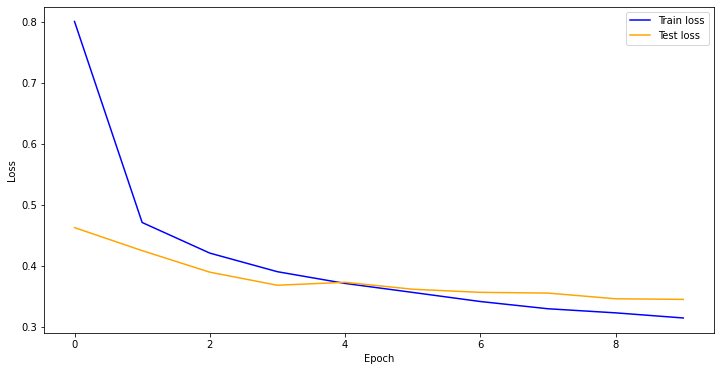

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(N_EPOCHS), history_train, c="blue", label="Train loss")
plt.plot(range(N_EPOCHS), history_test, c="orange", label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

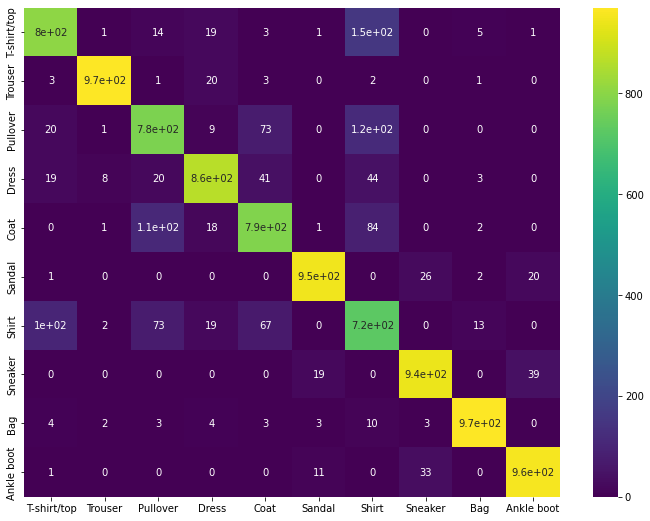

In [ ]:
make_confusion_matrix(test_mnist_dataloader, mnist_fc_model, FASHION_MNIST_TRAIN.classes, "cpu")

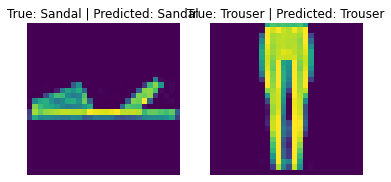

In [ ]:
with torch.inference_mode():
    example1, label1 = test_mnist_dataset[111]
    example2, label2 = test_mnist_dataset[777]
    pred1 = torch.argmax(mnist_fc_model(example1.unsqueeze(0)))
    pred2 = torch.argmax(mnist_fc_model(example2.unsqueeze(0)))
fashion_mnist_classes = FASHION_MNIST_TRAIN.classes
plt.subplot(1, 2, 1)
plt.imshow(example1.reshape(28, 28))
plt.title(f"True: {fashion_mnist_classes[label1]} | Predicted: {fashion_mnist_classes[pred1]}")
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(example2.reshape(28, 28))
plt.title(f"True: {fashion_mnist_classes[label2]} | Predicted: {fashion_mnist_classes[pred2]}")
plt.axis(False);

In [ ]:
torch.save(mnist_fc_model.state_dict(), "mnist_fully_connected.pth")

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [ ]:
class MNISTDataset(Dataset):
    
    def __init__(self,
                 train: bool = True,
                 transforms=None):
        if train:
            self.X = FASHION_MNIST_TRAIN.data
            self.y = FASHION_MNIST_TRAIN.targets
        else:
            self.X = FASHION_MNIST_TEST.data
            self.y = FASHION_MNIST_TEST.targets
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        x = self.X[index]
        y = self.y[index]
        if self.transforms:
            x = self.transforms(x)
            x = x.unsqueeze(0)
        return x, y

    def __len__(self):
        return self.X.shape[0]

In [ ]:
class MNISTConvModel(nn.Module):
    
    def __init__(self,
                 in_channels: int,
                 hidden_channels: int,
                 out_neurons: int,
                 apply_softmax: bool = False):
        super(MNISTConvModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=hidden_channels,
                               out_channels=hidden_channels * 3,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flattener = nn.Flatten()
        self.fc = nn.Linear(hidden_channels * 3 * 7 * 7, out_neurons)
        self.batch_norm1 = nn.BatchNorm2d(hidden_channels)
        self.batch_norm2 = nn.BatchNorm2d(hidden_channels * 3)
        self.relu = nn.LeakyReLU(0.1)
        self.softmax = nn.Softmax()
        self.apply_softmax = apply_softmax
        
    def forward(self, x: torch.Tensor):
        output = self.relu(self.batch_norm1(self.pool1(self.conv1(x))))
        output = self.relu(self.batch_norm2(self.pool2(self.conv2(output))))
        output = self.flattener(output)
        output = self.fc(output)
        if self.apply_softmax:
            return self.softmax(output)
        else:
            return output

In [ ]:
mnist_transforms = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
])

train_mnist_dataset = MNISTDataset(transforms=mnist_transforms)
test_mnist_dataset = MNISTDataset(train=False, transforms=mnist_transforms)

train_mnist_dataloader = DataLoader(train_mnist_dataset, batch_size=32, shuffle=True)
test_mnist_dataloader = DataLoader(test_mnist_dataset, batch_size=32)

In [ ]:
mnist_conv_model = MNISTConvModel(1, 6, 10)
mnist_conv_model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_conv_model.parameters(), lr=0.005)
N_EPOCHS = 10

In [ ]:
history_train, history_test = classification_loop(
    train_mnist_dataloader,
    test_mnist_dataloader,
    mnist_conv_model,
    criterion,
    optimizer,
    N_EPOCHS,
    DEVICE
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.3733745603422324 | Train acc: 0.8664166666666666 | Test loss: 0.33877096071648904 |Test acc: 0.8758985623003195
Epoch: 1 | Train loss: 0.2936301203250885 | Train acc: 0.8937333333333334 | Test loss: 0.310593160625083 |Test acc: 0.8865814696485623
Epoch: 2 | Train loss: 0.26941573064923285 | Train acc: 0.9022166666666667 | Test loss: 0.33100886066881613 |Test acc: 0.8866813099041534
Epoch: 3 | Train loss: 0.25457249204715093 | Train acc: 0.9074833333333333 | Test loss: 0.29184079080367814 |Test acc: 0.891573482428115
Epoch: 4 | Train loss: 0.24291829091608524 | Train acc: 0.91065 | Test loss: 0.3149316272201439 |Test acc: 0.8901757188498403
Epoch: 5 | Train loss: 0.23241740161329508 | Train acc: 0.9141166666666667 | Test loss: 0.2990347926680463 |Test acc: 0.8945686900958466
Epoch: 6 | Train loss: 0.22910856326570114 | Train acc: 0.9164333333333333 | Test loss: 0.2976405067256274 |Test acc: 0.8940694888178914
Epoch: 7 | Train loss: 0.22154266230563321 | Train ac

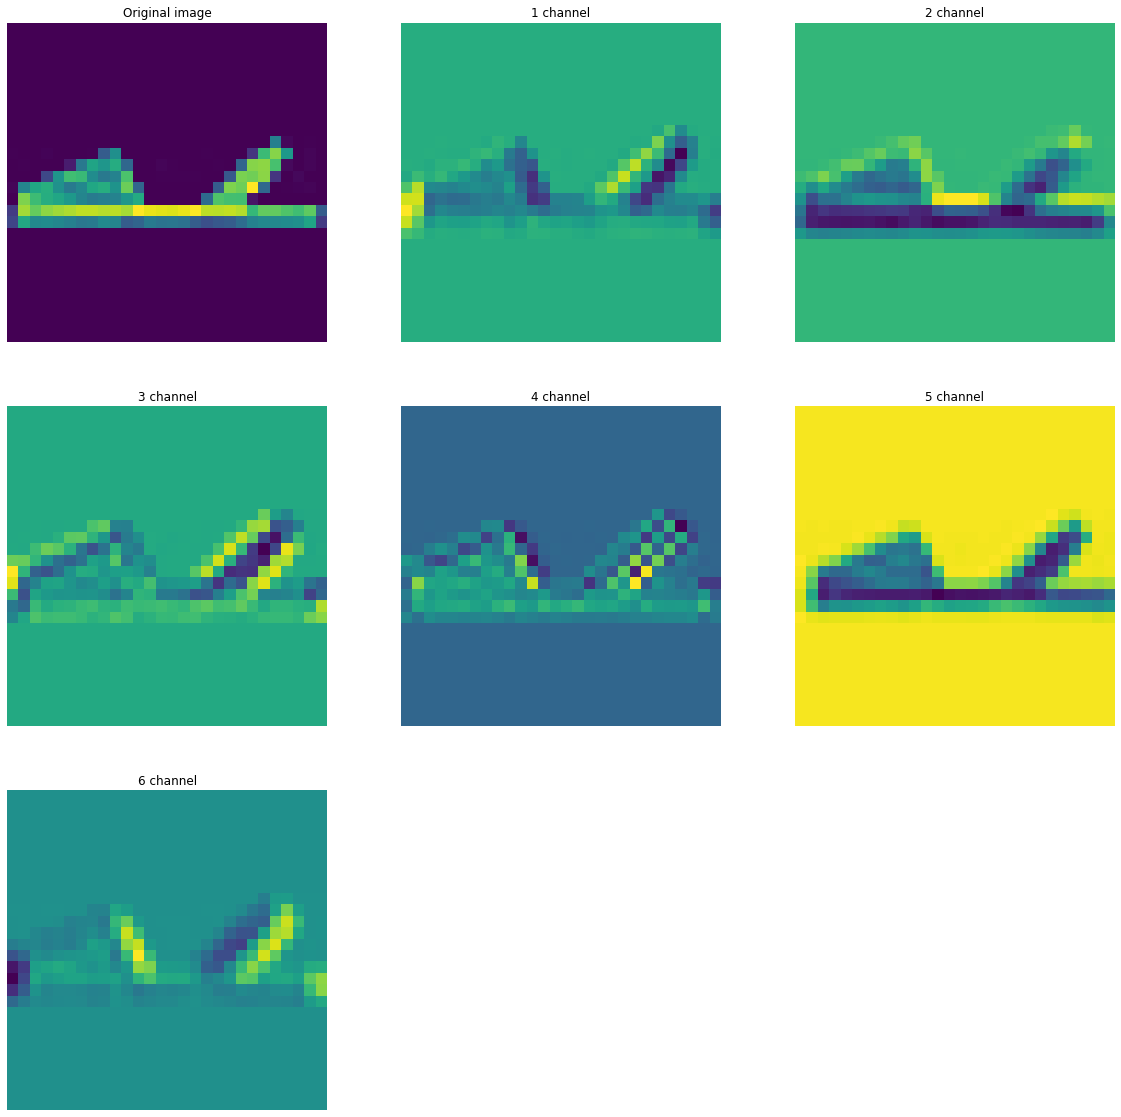

In [ ]:
with torch.inference_mode():
    example, label = test_mnist_dataset[111]
    example = example.to(DEVICE)
    first_conv_res = mnist_conv_model.conv1(example)
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 1)
plt.imshow(example.cpu().squeeze(0))
plt.title(f"Original image")
plt.axis(False)
for i in range(6):
    plt.subplot(3, 3, i + 2)
    plt.imshow(first_conv_res[i].cpu())
    plt.title(f"{i + 1} channel")
    plt.axis(False)

In [ ]:
torch.save(mnist_conv_model.state_dict(), "mnist_convolution.pth")

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [ ]:
class CIFARDataset(Dataset):
    
    def __init__(self,
                 train: bool = True,
                 transforms=None):
        if train:
            self.X = CIFAR_TRAIN.data
            self.y = CIFAR_TRAIN.targets
        else:
            self.X = CIFAR_TEST.data
            self.y = CIFAR_TEST.targets
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        x = self.X[index]
        y = self.y[index]
        if self.transforms:
            x = self.transforms(x)
        x = torch.flatten(x)
        return x, y

    def __len__(self):
        return self.X.shape[0]

In [ ]:
class CIFARFCModel(nn.Module):
    
    def __init__(self,
                 in_neurons: int,
                 hidden_neurons: int,
                 out_neurons: int,
                 apply_softmax: bool = False):
        super(CIFARFCModel, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, hidden_neurons * 2)
        self.fc3 = nn.Linear(hidden_neurons * 2, hidden_neurons * 4)
        self.fc4 = nn.Linear(hidden_neurons * 4, out_neurons)
        self.batch_norm1 = nn.BatchNorm1d(hidden_neurons)
        self.batch_norm2 = nn.BatchNorm1d(hidden_neurons * 2)
        self.batch_norm3 = nn.BatchNorm1d(hidden_neurons * 4)
        self.relu = nn.LeakyReLU(0.1)
        self.softmax = nn.Softmax()
        self.apply_softmax = apply_softmax
        
    def forward(self, x: torch.Tensor):
        output = self.relu(self.batch_norm1(self.fc1(x)))
        output = self.relu(self.batch_norm2(self.fc2(output)))
        output = self.relu(self.batch_norm3(self.fc3(output)))
        if self.apply_softmax:
            return self.softmax(output)
        else:
            return output

In [ ]:
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
])

train_cifar_dataset = CIFARDataset(transforms=cifar_transforms)
test_cifar_dataset = CIFARDataset(train=False, transforms=cifar_transforms)

train_cifar_dataloader = DataLoader(train_cifar_dataset, batch_size=32, shuffle=True)
test_cifar_dataloader = DataLoader(test_cifar_dataset, batch_size=32)

In [ ]:
cifar_fc_model = CIFARFCModel(32 * 32 * 3, 64, 10)
print("Number of parameters:",
      sum(p.shape[0] * p.shape[1] if len(p.shape) == 2 else p.shape[0] for p in cifar_fc_model.parameters()))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar_fc_model.parameters(), lr=0.005)
N_EPOCHS = 10

Number of parameters: 241482


In [ ]:
history_train, history_test = classification_loop(
    train_cifar_dataloader,
    test_cifar_dataloader,
    cifar_fc_model,
    criterion,
    optimizer,
    N_EPOCHS
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.3822615701879206 | Train acc: 0.3819177863083813 | Test loss: 1.7904832085100606 |Test acc: 0.4307108626198083
Epoch: 1 | Train loss: 1.659040714255984 | Train acc: 0.4419985604606526 | Test loss: 1.6173508266290537 |Test acc: 0.4514776357827476
Epoch: 2 | Train loss: 1.5349405701161956 | Train acc: 0.4678902751119642 | Test loss: 1.477116003584938 |Test acc: 0.4837260383386581
Epoch: 3 | Train loss: 1.4619709135093373 | Train acc: 0.4869041906589891 | Test loss: 1.6337364847286822 |Test acc: 0.42631789137380194
Epoch: 4 | Train loss: 1.4169289364848316 | Train acc: 0.4965611004478567 | Test loss: 1.4241386265419542 |Test acc: 0.503694089456869
Epoch: 5 | Train loss: 1.3700582131085606 | Train acc: 0.5133557261676264 | Test loss: 1.4331846090551383 |Test acc: 0.4891174121405751
Epoch: 6 | Train loss: 1.3383142539345905 | Train acc: 0.5217530390275112 | Test loss: 1.4382720225916121 |Test acc: 0.4931110223642173
Epoch: 7 | Train loss: 1.3110813203715241 | Train 

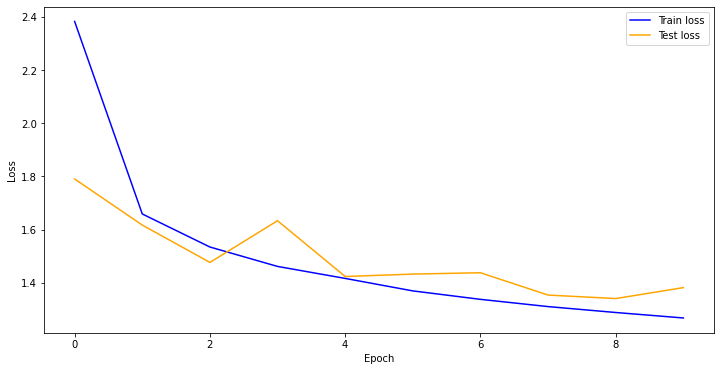

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(N_EPOCHS), history_train, c="blue", label="Train loss")
plt.plot(range(N_EPOCHS), history_test, c="orange", label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

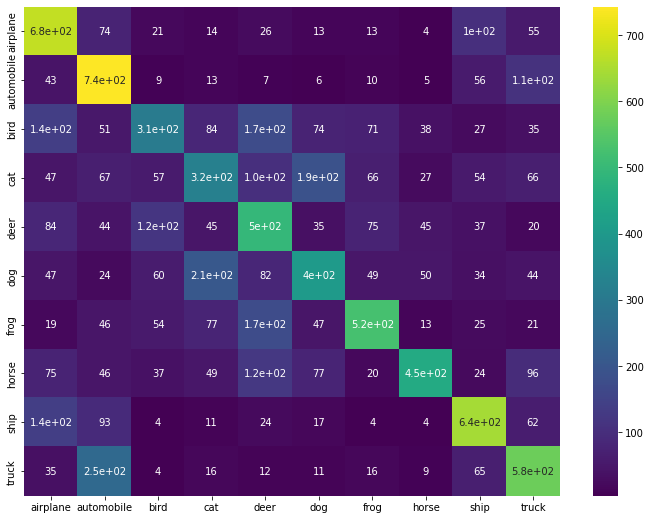

In [ ]:
make_confusion_matrix(test_cifar_dataloader, cifar_fc_model, CIFAR_TRAIN.classes, "cpu")

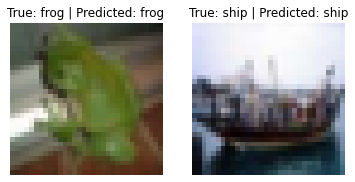

In [ ]:
with torch.inference_mode():
    example1, label1 = test_cifar_dataset[7]
    example2, label2 = test_cifar_dataset[18]
    pred1 = torch.argmax(cifar_fc_model(example1.unsqueeze(0)))
    pred2 = torch.argmax(cifar_fc_model(example2.unsqueeze(0)))
plt.subplot(1, 2, 1)
# Make permute, because ToTensor() converts from 32x32x3 to 3x32x32
plt.imshow(example1.reshape(3, 32, 32).permute(1, 2, 0))
plt.title(f"True: {CIFAR_TRAIN.classes[label1]} | Predicted: {CIFAR_TRAIN.classes[pred1]}")
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(example2.reshape(3, 32, 32).permute(1, 2, 0))
plt.title(f"True: {CIFAR_TRAIN.classes[label2]} | Predicted: {CIFAR_TRAIN.classes[pred2]}")
plt.axis(False);

In [ ]:
torch.save(cifar_fc_model.state_dict(), "cifar_fully_connected.pth")

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

In [ ]:
class CIFARDataset(Dataset):
    
    def __init__(self,
                 train: bool = True,
                 transforms=None):
        if train:
            self.X = CIFAR_TRAIN.data
            self.y = CIFAR_TRAIN.targets
        else:
            self.X = CIFAR_TEST.data
            self.y = CIFAR_TEST.targets
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        x = self.X[index]
        y = self.y[index]
        if self.transforms:
            x = self.transforms(x)
        return x, y

    def __len__(self):
        return self.X.shape[0]

In [ ]:
class CIFARConvModel(nn.Module):
    
    def __init__(self,
                 in_channels: int,
                 hidden_channels: int,
                 out_neurons: int,
                 apply_softmax: bool = False):
        super(CIFARConvModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=hidden_channels,
                               out_channels=hidden_channels * 3,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=hidden_channels * 3,
                               out_channels=hidden_channels * 6,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flattener = nn.Flatten()
        self.fc = nn.Linear(hidden_channels * 6 * 4 * 4, out_neurons)
        self.batch_norm1 = nn.BatchNorm2d(hidden_channels)
        self.batch_norm2 = nn.BatchNorm2d(hidden_channels * 3)
        self.batch_norm3 = nn.BatchNorm2d(hidden_channels * 6)
        self.relu = nn.LeakyReLU(0.1)
        self.softmax = nn.Softmax()
        self.apply_softmax = apply_softmax
        
    def forward(self, x: torch.Tensor):
        output = self.relu(self.batch_norm1(self.pool1(self.conv1(x))))
        output = self.relu(self.batch_norm2(self.pool2(self.conv2(output))))
        output = self.relu(self.batch_norm3(self.pool3(self.conv3(output))))
        output = self.flattener(output)
        output = self.fc(output)
        if self.apply_softmax:
            return self.softmax(output)
        else:
            return output

In [ ]:
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
])

train_cifar_dataset = CIFARDataset(transforms=cifar_transforms)
test_cifar_dataset = CIFARDataset(train=False, transforms=cifar_transforms)

train_cifar_dataloader = DataLoader(train_cifar_dataset, batch_size=32, shuffle=True)
test_cifar_dataloader = DataLoader(test_cifar_dataset, batch_size=32)

In [ ]:
cifar_conv_model = CIFARConvModel(3, 6, 10)
cifar_conv_model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar_conv_model.parameters(), lr=0.005)
N_EPOCHS = 15

In [ ]:
history_train, history_test = classification_loop(
    train_cifar_dataloader,
    test_cifar_dataloader,
    cifar_conv_model,
    criterion,
    optimizer,
    N_EPOCHS,
    DEVICE
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.2782242643245885 | Train acc: 0.5463651631477927 | Test loss: 1.1780469899360364 |Test acc: 0.5912539936102237
Epoch: 1 | Train loss: 1.023163827161185 | Train acc: 0.6420945297504799 | Test loss: 0.978787427893081 |Test acc: 0.6652356230031949
Epoch: 2 | Train loss: 0.940958852235583 | Train acc: 0.6712252079334613 | Test loss: 0.9468240991187172 |Test acc: 0.6759185303514377
Epoch: 3 | Train loss: 0.8893069163279432 | Train acc: 0.6890195137555982 | Test loss: 0.9889545069334987 |Test acc: 0.6637380191693291
Epoch: 4 | Train loss: 0.8546319909951509 | Train acc: 0.7005558221369161 | Test loss: 0.9354243162341012 |Test acc: 0.6849041533546326
Epoch: 5 | Train loss: 0.8265592990322748 | Train acc: 0.7117122520793346 | Test loss: 0.9326169289910374 |Test acc: 0.685702875399361
Epoch: 6 | Train loss: 0.8083335357793844 | Train acc: 0.7195497440818938 | Test loss: 0.8977082308869773 |Test acc: 0.6916932907348243
Epoch: 7 | Train loss: 0.787386159941087 | Train acc

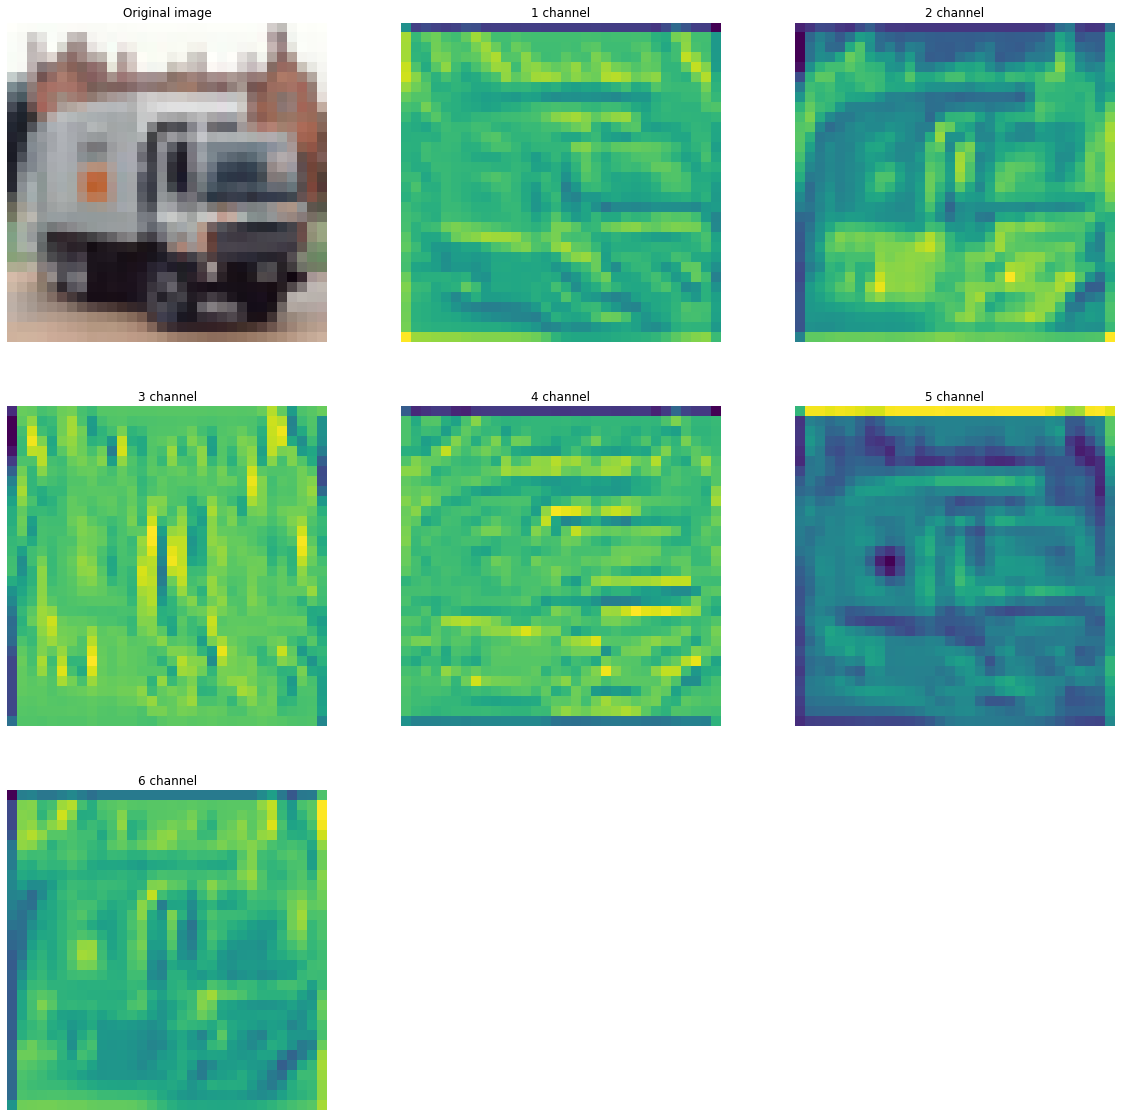

In [ ]:
with torch.inference_mode():
    example, label = test_cifar_dataset[11]
    example = example.to(DEVICE)
    first_conv_res = cifar_conv_model.conv1(example)
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 1)
plt.imshow(example.cpu().permute(1, 2, 0))
plt.title(f"Original image")
plt.axis(False)
for i in range(6):
    plt.subplot(3, 3, i + 2)
    plt.imshow(first_conv_res[i].cpu())
    plt.title(f"{i + 1} channel")
    plt.axis(False)

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
monkey_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((400, 400))
])
train_monkey_dataset = torchvision.datasets.ImageFolder(
    root="drive/MyDrive/data/monkeys/training/training/",
    transform=monkey_transforms)
test_monkey_dataset = torchvision.datasets.ImageFolder(
    root="drive/MyDrive/data/monkeys/validation/validation/",
    transform=monkey_transforms)
train_monkey_dataloader = DataLoader(train_monkey_dataset, batch_size=32, shuffle=True)
test_monkey_dataloader = DataLoader(test_monkey_dataset, batch_size=32)

In [ ]:
class MonkeyConvModel(nn.Module):
    
    def __init__(self,
                 in_channels: int,
                 hidden_channels: int,
                 out_neurons: int,
                 apply_softmax: bool = False):
        super(MonkeyConvModel, self).__init__()
        # 3 x 400 x 400 
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channels,
                               kernel_size=7,
                               stride=1,
                               padding=1)
        # hc x 396 x 396
        self.pool1 = nn.MaxPool2d(2, 2)
        # hc x 198 x 198
        self.conv2 = nn.Conv2d(in_channels=hidden_channels,
                               out_channels=hidden_channels * 2,
                               kernel_size=5,
                               stride=1,
                               padding=0)
        # 2*hc x 194 x 194
        self.pool2 = nn.MaxPool2d(2, 2)
        # 2*hc x 97 x 97
        self.conv3 = nn.Conv2d(in_channels=hidden_channels * 2,
                               out_channels=hidden_channels * 4,
                               kernel_size=5,
                               stride=1,
                               padding=0)
        # 4*hc x 93 x 93
        self.pool3 = nn.MaxPool2d(3, 3)
        # 4*hc x 31 x 31
        self.conv4 = nn.Conv2d(in_channels=hidden_channels * 4,
                               out_channels=hidden_channels * 6,
                               kernel_size=4,
                               stride=1,
                               padding=0)
        # 6*hc x 28 x 28
        self.pool4 = nn.MaxPool2d(2, 2)
        # 6*hc x 14 x 14
        self.flattener = nn.Flatten()
        self.fc = nn.Linear(hidden_channels * 6 * 14 * 14, out_neurons)
        self.batch_norm1 = nn.BatchNorm2d(hidden_channels)
        self.batch_norm2 = nn.BatchNorm2d(hidden_channels * 2)
        self.batch_norm3 = nn.BatchNorm2d(hidden_channels * 4)
        self.batch_norm4 = nn.BatchNorm2d(hidden_channels * 6)
        self.relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax()
        self.apply_softmax = apply_softmax
        
    def forward(self, x: torch.Tensor):
        output = self.dropout(self.relu(self.batch_norm1(self.pool1(self.conv1(x)))))
        output = self.dropout(self.relu(self.batch_norm2(self.pool2(self.conv2(output)))))
        output = self.dropout(self.relu(self.batch_norm3(self.pool3(self.conv3(output)))))
        output = self.dropout(self.relu(self.batch_norm4(self.pool4(self.conv4(output)))))
        output = self.flattener(output)
        output = self.fc(output)
        if self.apply_softmax:
            return self.softmax(output)
        else:
            return output

In [ ]:
monkey_conv_model = MonkeyConvModel(3, 6, 10)
monkey_conv_model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(monkey_conv_model.parameters(), lr=0.01, )
N_EPOCHS = 20

In [ ]:
history_train, history_test = classification_loop(
    train_monkey_dataloader,
    test_monkey_dataloader,
    monkey_conv_model,
    criterion,
    optimizer,
    N_EPOCHS,
    DEVICE
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 4.395833485467094 | Train acc: 0.22593984944479806 | Test loss: 2.55379495355818 |Test acc: 0.3819444444444444
Epoch: 1 | Train loss: 1.8891593558447701 | Train acc: 0.4340695491858891 | Test loss: 1.6126162343555026 |Test acc: 0.4375
Epoch: 2 | Train loss: 1.3832858766828264 | Train acc: 0.5471804516656058 | Test loss: 1.6918496820661757 |Test acc: 0.4027777777777778
Epoch: 3 | Train loss: 1.20340142760958 | Train acc: 0.5939379692077636 | Test loss: 2.0758378075228796 |Test acc: 0.4409722222222222
Epoch: 4 | Train loss: 1.04496020759855 | Train acc: 0.6305451120649065 | Test loss: 1.7246090902222528 |Test acc: 0.4305555555555556
Epoch: 5 | Train loss: 0.900926366022655 | Train acc: 0.6971804516656058 | Test loss: 1.7303632696469624 |Test acc: 0.4826388888888889
Epoch: 6 | Train loss: 0.7207584917545319 | Train acc: 0.7621240598814828 | Test loss: 1.4722668064965143 |Test acc: 0.53125
Epoch: 7 | Train loss: 0.6892734859670911 | Train acc: 0.7686560153961182 | Te

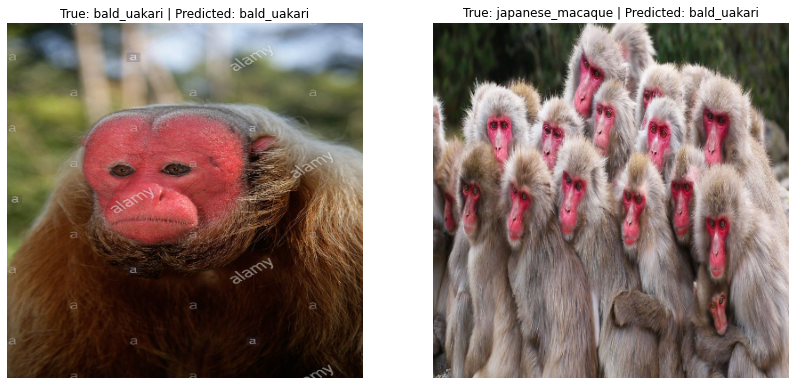

In [ ]:
with torch.inference_mode():
    example1, label1 = test_monkey_dataset[77]
    example2, label2 = test_monkey_dataset[88]
    pred1 = torch.argmax(monkey_conv_model(example1.unsqueeze(0).to(DEVICE))).cpu().item()
    pred2 = torch.argmax(monkey_conv_model(example2.unsqueeze(0).to(DEVICE))).cpu().item()

monkey_labels = pd.read_csv("drive/MyDrive/monkey_labels.txt", index_col=0)
monkey_labels = monkey_labels.iloc[:, 1]
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.imshow(example1.permute(1, 2, 0))
plt.title(f"True: {monkey_labels[label1].strip()} | Predicted: {monkey_labels[pred1].strip()}")
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(example2.permute(1, 2, 0))
plt.title(f"True: {monkey_labels[label2].strip()} | Predicted: {monkey_labels[pred2].strip()}")
plt.axis(False);

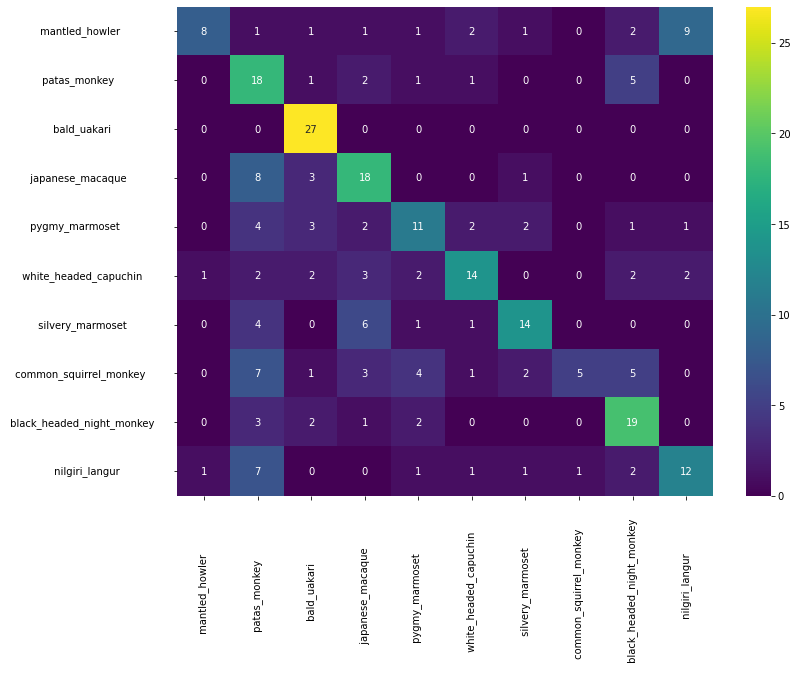

In [ ]:
make_confusion_matrix(test_monkey_dataloader, monkey_conv_model, monkey_labels, DEVICE)

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [37]:
import zipfile


zf = zipfile.ZipFile('drive/MyDrive/data/cats-dogs/cats_dogs.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

  0%|          | 0/25004 [00:00<?, ?it/s]

In [ ]:
cats_dogs_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((256, 256))
])
cats_dogs_dataset = torchvision.datasets.ImageFolder(
    root="cats_dogs/train",
    transform=cats_dogs_transforms)
indexes = torch.randperm(len(cats_dogs_dataset))
train_indexes = indexes[:20000]
test_indexes = indexes[20000:]
train_cats_dogs_dataloader = DataLoader(cats_dogs_dataset, batch_size=32, sampler=train_indexes)
test_cats_dogs_dataloader = DataLoader(cats_dogs_dataset, batch_size=32, sampler=test_indexes)

In [ ]:
class CatsDogsConvModel(nn.Module):
    
    def __init__(self,
                 in_channels: int,
                 hidden_channels: int,
                 out_neurons: int,
                 apply_softmax: bool = False):
        super(CatsDogsConvModel, self).__init__()
        # 3 x 256 x 256
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channels,
                               kernel_size=5,
                               stride=1,
                               padding=1)
        # hc x 254 x 254
        self.pool1 = nn.MaxPool2d(2, 2)
        # hc x 127 x 127
        self.conv2 = nn.Conv2d(in_channels=hidden_channels,
                               out_channels=hidden_channels * 2,
                               kernel_size=4,
                               stride=1,
                               padding=0)
        # 2*hc x 124 x 124
        self.pool2 = nn.MaxPool2d(2, 2)
        # 2*hc x 62 x 62
        self.conv3 = nn.Conv2d(in_channels=hidden_channels * 2,
                               out_channels=hidden_channels * 4,
                               kernel_size=5,
                               stride=1,
                               padding=0)
        # 4*hc x 58 x 58
        self.pool3 = nn.MaxPool2d(2, 2)
        # 4*hc x 29 x 29
        self.conv4 = nn.Conv2d(in_channels=hidden_channels * 4,
                               out_channels=hidden_channels * 8,
                               kernel_size=4,
                               stride=1,
                               padding=0)
        # 8*hc x 26 x 26
        self.pool4 = nn.MaxPool2d(2, 2)
        # 8*hc x 13 x 13
        self.flattener = nn.Flatten()
        self.fc = nn.Linear(hidden_channels * 8 * 13 * 13, out_neurons)
        self.batch_norm1 = nn.BatchNorm2d(hidden_channels)
        self.batch_norm2 = nn.BatchNorm2d(hidden_channels * 2)
        self.batch_norm3 = nn.BatchNorm2d(hidden_channels * 4)
        self.batch_norm4 = nn.BatchNorm2d(hidden_channels * 8)
        self.relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.3)
        self.softmax = nn.Softmax()
        self.apply_softmax = apply_softmax
        
    def forward(self, x: torch.Tensor):
        output = self.dropout(self.relu(self.batch_norm1(self.pool1(self.conv1(x)))))
        output = self.dropout(self.relu(self.batch_norm2(self.pool2(self.conv2(output)))))
        output = self.dropout(self.relu(self.batch_norm3(self.pool3(self.conv3(output)))))
        output = self.dropout(self.relu(self.batch_norm4(self.pool4(self.conv4(output)))))
        output = self.flattener(output)
        output = self.fc(output)
        if self.apply_softmax:
            return self.softmax(output)
        else:
            return output

In [ ]:
cats_dogs_conv_model = CatsDogsConvModel(3, 5, 10)
cats_dogs_conv_model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cats_dogs_conv_model.parameters(), lr=0.012)
N_EPOCHS = 10

In [ ]:
history_train, history_test = classification_loop(
    train_cats_dogs_dataloader,
    test_cats_dogs_dataloader,
    cats_dogs_conv_model,
    criterion,
    optimizer,
    N_EPOCHS,
    DEVICE
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.9376031302452087 | Train acc: 0.56095 | Test loss: 0.6959092706252056 |Test acc: 0.5867834394904459
Epoch: 1 | Train loss: 0.6463160672187805 | Train acc: 0.6405 | Test loss: 0.6376501169933635 |Test acc: 0.6367436305732485
Epoch: 2 | Train loss: 0.6111400564670563 | Train acc: 0.67275 | Test loss: 0.6262572434297793 |Test acc: 0.647093949044586
Epoch: 3 | Train loss: 0.5857079503059387 | Train acc: 0.6938 | Test loss: 0.5728420582926197 |Test acc: 0.6878980891719745
Epoch: 4 | Train loss: 0.5506546432733536 | Train acc: 0.72485 | Test loss: 0.5958020153698648 |Test acc: 0.6803343949044586
Epoch: 5 | Train loss: 0.5233889626026154 | Train acc: 0.7426 | Test loss: 0.611431767226784 |Test acc: 0.6978503184713376
Epoch: 6 | Train loss: 0.5077246438503266 | Train acc: 0.75875 | Test loss: 0.6197257713907084 |Test acc: 0.7044187898089171
Epoch: 7 | Train loss: 0.5049831796646118 | Train acc: 0.7623 | Test loss: 0.5457888773292493 |Test acc: 0.7382563694267515
Epoch:

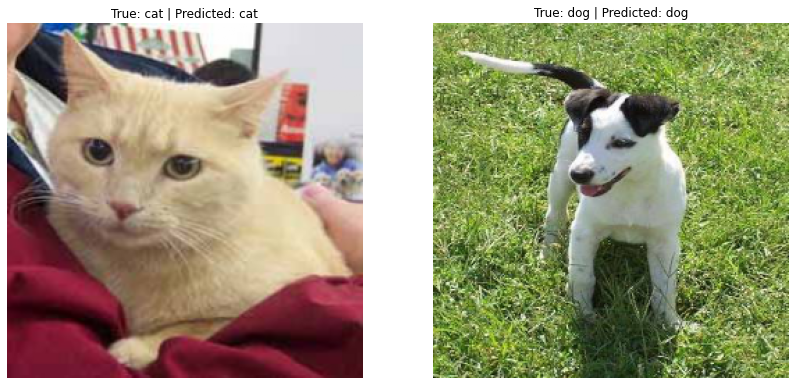

In [ ]:
with torch.inference_mode():
    example1, label1 = cats_dogs_dataset[77]
    example2, label2 = cats_dogs_dataset[20111]
    pred1 = torch.argmax(cats_dogs_conv_model(example1.unsqueeze(0).to(DEVICE))).cpu().item()
    pred2 = torch.argmax(cats_dogs_conv_model(example2.unsqueeze(0).to(DEVICE))).cpu().item()

cats_dogs_labels = cats_dogs_dataset.classes
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.imshow(example1.permute(1, 2, 0))
plt.title(f"True: {cats_dogs_labels[label1].strip()} | Predicted: {cats_dogs_labels[pred1].strip()}")
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(example2.permute(1, 2, 0))
plt.title(f"True: {cats_dogs_labels[label2].strip()} | Predicted: {cats_dogs_labels[pred2].strip()}")
plt.axis(False);

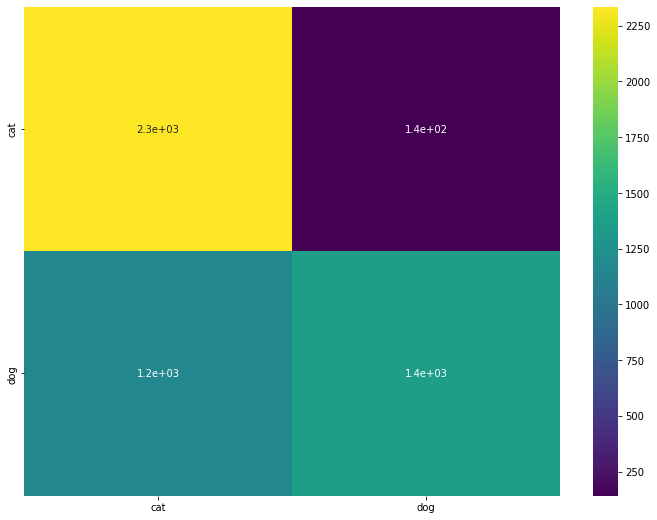

In [ ]:
make_confusion_matrix(test_cats_dogs_dataloader, cats_dogs_conv_model, cats_dogs_labels, DEVICE)

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


In [26]:
vgg16_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])
train_vgg_dataset = torchvision.datasets.ImageFolder(
    root="drive/MyDrive/data/monkeys/training/training/",
    transform=vgg16_transforms)
test_vgg_dataset = torchvision.datasets.ImageFolder(
    root="drive/MyDrive/data/monkeys/validation/validation/",
    transform=vgg16_transforms)
train_vgg_dataloader = DataLoader(train_vgg_dataset, batch_size=32, shuffle=True)
test_vgg_dataloader = DataLoader(test_vgg_dataset, batch_size=32)

In [27]:
vgg16 = torchvision.models.vgg16(torchvision.models.VGG16_Weights.IMAGENET1K_V1)
n_input_linear = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(n_input_linear, len(train_vgg_dataset.classes))
vgg16.to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0005)
N_EPOCHS = 10

In [29]:
history_train, history_test = classification_loop(
    train_vgg_dataloader,
    test_vgg_dataloader,
    vgg16,
    criterion,
    optimizer,
    N_EPOCHS,
    DEVICE
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.335627658026559 | Train acc: 0.09971804512398584 | Test loss: 2.295903126398722 |Test acc: 0.1284722222222222
Epoch: 1 | Train loss: 2.207741836139134 | Train acc: 0.1548402258328029 | Test loss: 2.111747052934435 |Test acc: 0.1701388888888889
Epoch: 2 | Train loss: 2.021761625153678 | Train acc: 0.25935150384902955 | Test loss: 1.9580769273969862 |Test acc: 0.2569444444444444
Epoch: 3 | Train loss: 1.7852468729019164 | Train acc: 0.3515507519245148 | Test loss: 1.6438824600643582 |Test acc: 0.3715277777777778
Epoch: 4 | Train loss: 1.5629228046962194 | Train acc: 0.426973683493478 | Test loss: 1.8630495733684964 |Test acc: 0.3506944444444444
Epoch: 5 | Train loss: 1.3326312388692583 | Train acc: 0.5180451120649066 | Test loss: 1.736854977077908 |Test acc: 0.3715277777777778
Epoch: 6 | Train loss: 1.1367210286004203 | Train acc: 0.6055451120649066 | Test loss: 1.5085077418221369 |Test acc: 0.4756944444444444
Epoch: 7 | Train loss: 0.9502401147569929 | Train acc

In [30]:
vgg16_freezed = torchvision.models.vgg16(torchvision.models.VGG16_Weights.IMAGENET1K_V1)
for parameter in vgg16_freezed.parameters():
    parameter.requires_grad = False
n_input_linear = vgg16_freezed.classifier[-1].in_features
vgg16_freezed.classifier[-1] = nn.Linear(n_input_linear, len(train_vgg_dataset.classes))
vgg16_freezed.to(DEVICE)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_freezed.parameters(), lr=0.001)
N_EPOCHS = 10

In [32]:
history_train, history_test = classification_loop(
    train_vgg_dataloader,
    test_vgg_dataloader,
    vgg16_freezed,
    criterion,
    optimizer,
    N_EPOCHS,
    DEVICE
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.4905587406030723 | Train acc: 0.867246241228921 | Test loss: 0.10349877054492633 |Test acc: 0.9722222222222222
Epoch: 1 | Train loss: 0.06818148360720702 | Train acc: 0.9866071428571429 | Test loss: 0.08369432886441548 |Test acc: 0.9722222222222222
Epoch: 2 | Train loss: 0.04919883922806808 | Train acc: 0.9892857142857143 | Test loss: 0.06551471704410182 |Test acc: 0.9791666666666666
Epoch: 3 | Train loss: 0.027906478489083904 | Train acc: 0.9964285714285714 | Test loss: 0.06487660865402883 |Test acc: 0.9791666666666666
Epoch: 4 | Train loss: 0.027186068267162355 | Train acc: 0.9958176698003497 | Test loss: 0.062332510430779725 |Test acc: 0.9826388888888888
Epoch: 5 | Train loss: 0.015488911879115871 | Train acc: 0.9991071428571429 | Test loss: 0.06340644974261522 |Test acc: 0.9791666666666666
Epoch: 6 | Train loss: 0.01613097729693566 | Train acc: 0.9991071428571429 | Test loss: 0.044968712557521134 |Test acc: 0.9861111111111112
Epoch: 7 | Train loss: 0.013025

### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [35]:
resnet18 = torchvision.models.resnet18(torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
for parameter in resnet18.parameters():
    parameter.requires_grad = False
n_input_linear = resnet18.fc.in_features
resnet18.fc = nn.Linear(n_input_linear, len(train_vgg_dataset.classes))
resnet18.to(DEVICE)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
resnet_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])
resnet_dataset = torchvision.datasets.ImageFolder(
    root="cats_dogs/train",
    transform=resnet_transforms)
indexes = torch.randperm(len(resnet_dataset))
train_indexes = indexes[:20000]
test_indexes = indexes[20000:]
train_resnet_dataloader = DataLoader(resnet_dataset, batch_size=32, sampler=train_indexes)
test_resnet_dataloader = DataLoader(resnet_dataset, batch_size=32, sampler=test_indexes)

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)
N_EPOCHS = 3

In [42]:
history_train, history_test = classification_loop(
    train_resnet_dataloader,
    test_resnet_dataloader,
    resnet18,
    criterion,
    optimizer,
    N_EPOCHS,
    DEVICE
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.14823166131079196 | Train acc: 0.9433 | Test loss: 0.06712090845107083 |Test acc: 0.9721337579617835
Epoch: 1 | Train loss: 0.08820316085144878 | Train acc: 0.96485 | Test loss: 0.0596605193953973 |Test acc: 0.9741242038216561
Epoch: 2 | Train loss: 0.08192181454002857 | Train acc: 0.9673 | Test loss: 0.05722031337920885 |Test acc: 0.9755175159235668
